# Init Environment

## Note

In [ ]:
# note of the module installations
# install python with pyenv (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv)
# setup virtual environment with pyenv (ref:https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv
# error: 'Failed to activate virtualenv' (ref:https://github.com/pyenv/pyenv-virtualenv/issues/387)
# pip install fasttext (0.9.2) (after installing the dependencies: numpy, scipy, pybind11, setuptools, wheel)

# install Jupyter notebook and nbextensions (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#jupyter-notebook-extensions)
#   pip install jupyter_contrib_nbextensions
#   pip install --upgrade notebook==6.4.12 (ref:https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear)
#   pip install traitlets==5.9.0

## Import modules

In [37]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm import tqdm
import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_text import *
from src.helper_langID import *
from src.helper_translation import *
from src.helper_pred import *

# Combine Data Source

In [ ]:
import glob

# Get a list of file paths that match the pattern
files = glob.glob(f'{DATA_FOLDER_PATH_RAW}/data_202*.xlsx')
# Create an empty list to store DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in files:
    df = pd.read_excel(file, index_col=None)
    dfs.append(df)

# Concatenate the DataFrames into one
df_combined = pd.concat(dfs, ignore_index=True)
df_combined.info()

In [ ]:
#check for null values
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# columns which have large number of null values will be dropped 
columns_to_drop = [
    'Escalated To Engineering', 
    'Bug Type', 
    'Status Reason', 
    'Escalated to L2',
    'Category',
    'Completion Code'
]
try: 
    df_combined.drop(columns_to_drop, axis=1, inplace = True)
    df_combined.dropna(subset=['Request ID'], inplace=True)
    df_combined.dropna(subset=['Product Name'], inplace=True)
    df_combined.dropna(subset=['Title'], inplace=True)
except:
    pass
# surprisingly, there are over 100k duplications
df_combined.drop_duplicates(subset=['Title', 'Product Name'], keep='first', inplace=True)

In [ ]:
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'

# Export the DataFrame to Excel
df_combined.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Load Data for Pre-processing

In [38]:
if 'df_combined' not in locals():
    data_url = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'
    df_combined = pd.read_excel(data_url, index_col=None)
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168829 entries, 0 to 168828
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             168829 non-null  int64         
 1   Title                  168829 non-null  object        
 2   Created Time           168829 non-null  datetime64[ns]
 3   Customer Company       168650 non-null  object        
 4   Customer Country       168729 non-null  object        
 5   Priority               168829 non-null  object        
 6   Urgency                168829 non-null  object        
 7   Impact                 168829 non-null  object        
 8   Product Name           168829 non-null  object        
 9   Module Name            158114 non-null  object        
 10  Service Definition     168820 non-null  object        
 11  Service Desk Group     167799 non-null  object        
 12  Status                 168829 non-null  obje

# Clean-up the Title Column

## Quick Clean-up

Processing Rows: 100%|██████████| 168829/168829 [00:13<00:00, 12259.26 row/s]


<class 'pandas.core.frame.DataFrame'>
Index: 142258 entries, 0 to 168828
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        142258 non-null  int64 
 1   Title             142258 non-null  object
 2   Product Name      142258 non-null  object
 3   Module Name       132565 non-null  object
 4   Title_Processed   142258 non-null  object
 5   Language          0 non-null       object
 6   Length            142258 non-null  int64 
 7   Title_Translated  0 non-null       object
 8   Title_Enhanced    0 non-null       object
 9   Tags              0 non-null       object
dtypes: int64(2), object(8)
memory usage: 11.9+ MB
None


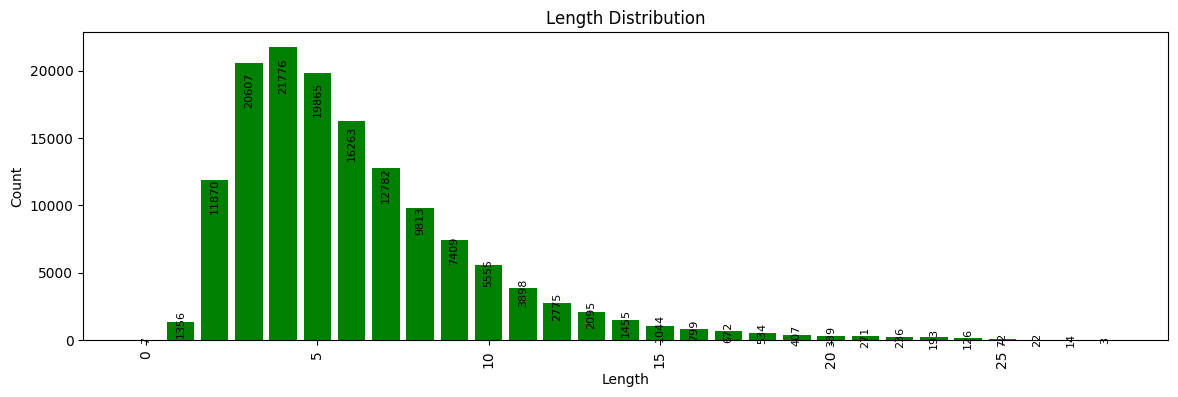

,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
0,1705753,OFM Support,OFM,Base,OFM Support,<NA>,2,<NA>,<NA>,<NA>
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,Rerun workflow and Create workflow option not ...,<NA>,8,<NA>,<NA>,<NA>
2,1130330,[Ext] TR- Registration Completion Notice,ECLIPSE,Eclipse 100 (Blackoil),Registration Completion Notice,<NA>,3,<NA>,<NA>,<NA>
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,Patch for proSource .,<NA>,3,<NA>,<NA>,<NA>
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,issue with ProSource services,<NA>,4,<NA>,<NA>,<NA>
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,ProSource new License file,<NA>,4,<NA>,<NA>,<NA>
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,License,NaN,Schlumberger Licensing Tool . not starting,<NA>,5,<NA>,<NA>,<NA>
7,1135119,Production by zone/segment,Petrel RE,Simulation,Production by zone segment,<NA>,4,<NA>,<NA>,<NA>
8,1136751,data exchanger with client,Petrel,Geology,data exchanger with client,<NA>,4,<NA>,<NA>,<NA>
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,"Error Unable to start external queue, but runn...",<NA>,9,<NA>,<NA>,<NA>


In [52]:
df_processed = df_combined.copy()

# Delete unnecessary columns, add needed columns
df_processed.drop(columns=[
    'Created Time', 
    'Customer Company', 'Customer Country', 
    'Priority', 'Urgency', 'Impact', 
    'Service Definition', 'Service Desk Group', 'Status',
    'Closed Time', 
    'Response Time (Min)', 'Resolution Time (Min)', 
    'Contracts Reference', 'Creation Source'
    ], inplace=True)

# Add new columns
df_processed['Title_Processed']=pd.NA
df_processed['Language']=pd.NA
df_processed['Length'] = 0
df_processed['Title_Translated']=pd.NA
df_processed['Title_Enhanced']=pd.NA
df_processed['Tags']=pd.NA

# Run quick clean up on the 'Title' column and save the result to the 'Title_Processed' column

# Set the number of rows to process
num = df_processed['Title'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    # processed_title = preprocess_step_1(df_combined.at[index, 'Title'])
    processed_title = quick_clean_up(df_processed.at[index, 'Title'])
    df_processed.at[index, 'Title_Processed'] = processed_title
    df_processed.at[index, 'Length'] = count_words(processed_title)
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

# Delete records with missing values in 'Title_Processed' columns
df_processed.dropna(subset=['Title_Processed'], inplace=True)

# Remove duplicates based on 'Title_Processed' and 'ProductName' columns
df_processed.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)

print(df_processed.info())
hist_by_labels(df_processed, 'Length', log=False)

df_processed.head(30)

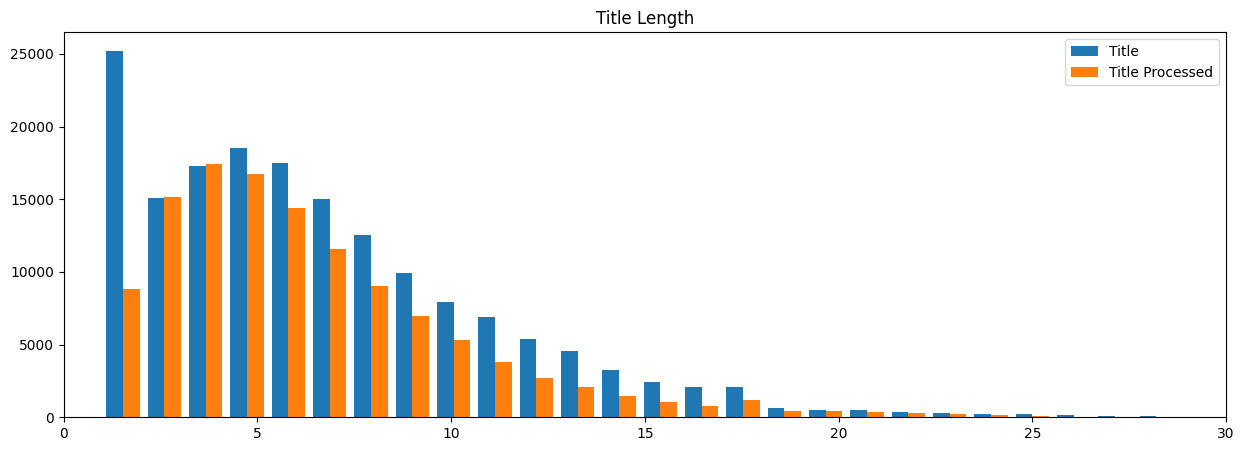

In [73]:
len_title = df_combined['Title'].apply(lambda x: len(x.split()))
len_title_processed = df_processed['Title_Processed'].apply(lambda x: len(x.split()))

# plot two histograms sidd by side in one plot
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes.hist([len_title, len_title_processed], bins=30)
#set X-axis limit
axes.set_xlim(0, 30)
axes.set_title('Title Length')
plt.legend(['Title', 'Title Processed'])
plt.show()

## Language Detection

Processing Rows:   0%|          | 0/142258 [00:00<?, ? row/s]

Processing Rows: 100%|██████████| 142258/142258 [00:07<00:00, 19409.41 row/s]


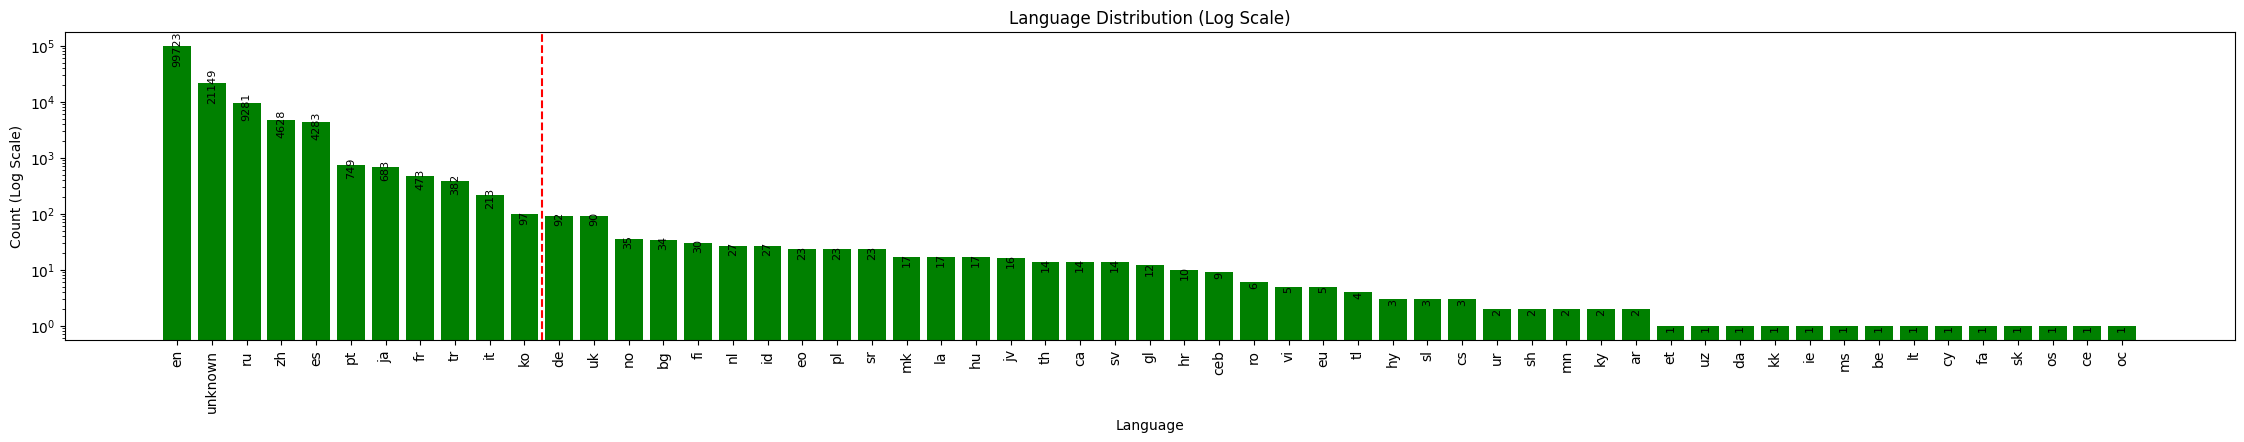

Language detected with low confidence: 14.867%.


,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
0,1705753,OFM Support,OFM,Base,OFM Support,en,2,<NA>,<NA>,<NA>
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,Rerun workflow and Create workflow option not ...,en,8,<NA>,<NA>,<NA>
2,1130330,[Ext] TR- Registration Completion Notice,ECLIPSE,Eclipse 100 (Blackoil),Registration Completion Notice,en,3,<NA>,<NA>,<NA>
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,Patch for proSource .,en,3,<NA>,<NA>,<NA>
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,issue with ProSource services,en,4,<NA>,<NA>,<NA>
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,ProSource new License file,en,4,<NA>,<NA>,<NA>
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,License,NaN,Schlumberger Licensing Tool . not starting,en,5,<NA>,<NA>,<NA>
7,1135119,Production by zone/segment,Petrel RE,Simulation,Production by zone segment,en,4,<NA>,<NA>,<NA>
8,1136751,data exchanger with client,Petrel,Geology,data exchanger with client,en,4,<NA>,<NA>,<NA>
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,"Error Unable to start external queue, but runn...",en,9,<NA>,<NA>,<NA>


In [55]:
# Run language detection on the 'Title_Processed' column and save the result to the 'Language' column
# This is the step required to run bulk language translation using Google Translate API for performance reason
# The language detection is done using FastText library since FastText is better than the langdetect library and other options.
# ref: https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad
# FastText has difficulty detecting CJK languages mixed with English, so we will use udf-8 encoding to detect CJK languages directly.

# Set the number of rows to process
num = df_processed['Title_Processed'].notnull().sum()

# df['Title_Translated'] = df['Title_Processed']
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_processed.at[index, 'Language'] = detect_language_fasttext(df_processed.at[index, 'Title_Processed'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)

print(f"Language detected with low confidence: \033[94m{df_processed['Language'].value_counts(normalize=True)['unknown'] * 100:.3f}%\033[0m.")
df_processed.head(20)

In [56]:
# Keep the top languages which has at least 100 records. Drop the rests.
# why? There are high chances the detected language were not correct due to wrong spelling, etc.
language_counts = df_processed['Language'].value_counts()
cutoff = 100 # Keep the top 9 languages.
language_others = language_counts.index[language_counts < cutoff]

mask_others = df_processed['Language'].isin(language_others)
df_processed.loc[mask_others,'Language']='unknown'

# Drop rows where 'Language' is equal to 'unknown'
df_detection_unknown = df_processed[df_processed['Language'] == 'unknown']
df_processed = df_processed[df_processed['Language'] != 'unknown']

print(f"Language detected with low confidence: \033[94m{df_detection_unknown.shape[0]}\033[0m.")
print(df_processed.info())
print(df_detection_unknown.info())

Language detected with low confidence: 21843.
<class 'pandas.core.frame.DataFrame'>
Index: 120415 entries, 0 to 168828
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        120415 non-null  int64 
 1   Title             120415 non-null  object
 2   Product Name      120415 non-null  object
 3   Module Name       112273 non-null  object
 4   Title_Processed   120415 non-null  object
 5   Language          120415 non-null  object
 6   Length            120415 non-null  int64 
 7   Title_Translated  0 non-null       object
 8   Title_Enhanced    0 non-null       object
 9   Tags              0 non-null       object
dtypes: int64(2), object(8)
memory usage: 10.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 21843 entries, 29 to 168811
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        21843 n

In [57]:
# Save the DataFrame to Excel for future steps without having to run the previous steps again
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
df_processed.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m saved')

excel_file_unknown = f'{DATA_FOLDER_PATH_PROCESSED}/data_langID_unknown.xlsx'
df_detection_unknown.to_excel(excel_file_unknown, index=False)
print(f'\033[94m{excel_file_unknown}\033[0m saved')

../data/processed/data_processed.xlsx saved
../data/processed/data_langID_unknown.xlsx saved


,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
29,1179713,Chargement Petrel,Petrel,Geophysics Core,Chargement Petrel,unknown,2,<NA>,<NA>,<NA>
32,1192136,[Ext] Segment Index,Petrel,Modeling,Segment Index,unknown,2,<NA>,<NA>,<NA>
47,1231918,XY Coordonate,Avocet,Others,XY Coordonate,unknown,2,<NA>,<NA>,<NA>
49,1234035,Update Avocet,Avocet,Others,Update Avocet,unknown,2,<NA>,<NA>,<NA>
50,1235320,SH-EXPLO: chargement des donnees VSP sur ProSo...,ProSource,ProSource Logs,EXPLO chargement des donnees VSP sur ProSource...,unknown,8,<NA>,<NA>,<NA>
52,1237431,SH-EXPLO:la table Dataset version vide,ProSource,ProSource Seismic,EXPLO la table Dataset version vide,unknown,6,<NA>,<NA>,<NA>
55,1238068,SH-EXPLO: Changer le path des donnees seismic ...,ProSource,ProSource Seismic,EXPLO Changer le path des donnees seismic data...,unknown,9,<NA>,<NA>,<NA>
77,1258554,1-1O4RWZ3 | DELFI: Image update,Petrotechnical Suite - Domain Profiles,Ocean Plug-ins for Techlog - SLB,DELFI Image update,unknown,3,<NA>,<NA>,<NA>
78,1258588,"Facies modeling and variogram parameters,",Petrel,GCCore,"Facies modeling and variogram parameters,",unknown,5,<NA>,<NA>,<NA>
81,1260808,image digitalise,Techlog,Import/Export,image digitalise,unknown,2,<NA>,<NA>,<NA>


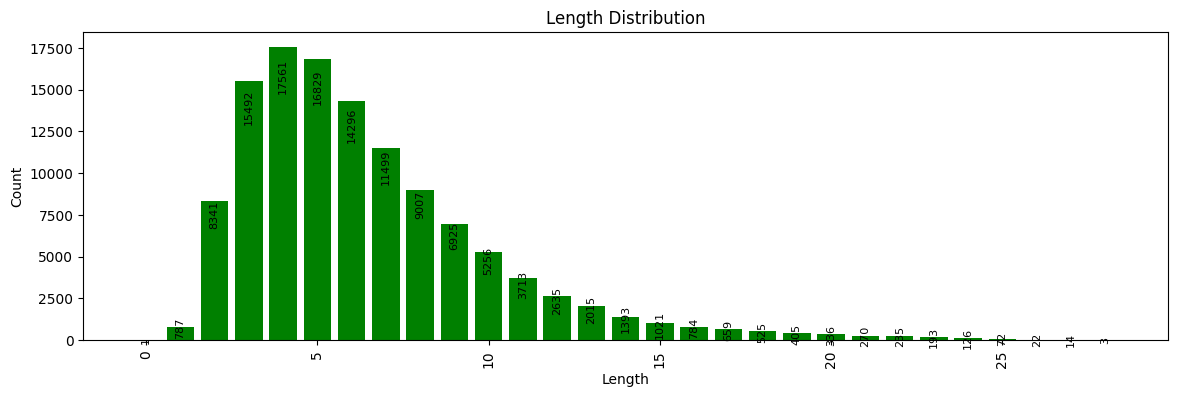

In [60]:
display(df_detection_unknown.head(20))
hist_by_labels(df_processed, "Length", log=False)

## Translation of Non-English

In [61]:
# Translate the 'Title_Processed' column and save the result to the 'Title_Translated' column
# language by language to avoid Google Translate API quota limit
# skip English obviously
# the length limit is 1250 characters due to Google Translate API limit for CJK languages
# load the processed data df_processed if not loaded yet
if 'df_processed' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
    df_processed = pd.read_excel(excel_file)

df_translated = df_processed.copy()
df_translated['Title_Translated'] = df_translated['Title_Processed']

grouped = df_translated.groupby("Language")

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Translating")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for lang, group in grouped:
    pbar.set_description(f"Processing [\033[94m{lang}/{len(group)}\033[0m]")

    translated_titles = translate_array(
        group["Title_Translated"].tolist(),
        src_lang=lang,
        tar_lang='en',
        length_limit=1250)
    group["Title_Translated"] = translated_titles  # Update "Title_Translated" column in the group
    
    processed_groups.append(group)
    pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_translated = pd.concat(processed_groups, ignore_index=True)

Processing [zh/4628]: 100%|██████████| 9/9 [03:42<00:00, 24.67s/it]


In [63]:
df_translated.head(30)

,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
0,1705753,OFM Support,OFM,Base,OFM Support,en,2,OFM Support,NaN,NaN
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,Rerun workflow and Create workflow option not ...,en,8,Rerun workflow and Create workflow option not ...,NaN,NaN
2,1130330,[Ext] TR- Registration Completion Notice,ECLIPSE,Eclipse 100 (Blackoil),Registration Completion Notice,en,3,Registration Completion Notice,NaN,NaN
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,Patch for proSource .,en,3,Patch for proSource .,NaN,NaN
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,issue with ProSource services,en,4,issue with ProSource services,NaN,NaN
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,ProSource new License file,en,4,ProSource new License file,NaN,NaN
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,License,NaN,Schlumberger Licensing Tool . not starting,en,5,Schlumberger Licensing Tool . not starting,NaN,NaN
7,1135119,Production by zone/segment,Petrel RE,Simulation,Production by zone segment,en,4,Production by zone segment,NaN,NaN
8,1136751,data exchanger with client,Petrel,Geology,data exchanger with client,en,4,data exchanger with client,NaN,NaN
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,"Error Unable to start external queue, but runn...",en,9,"Error Unable to start external queue, but runn...",NaN,NaN


In [64]:
# Delete records with missing values in 'Title_Translated' columns
# there should be no missing values in 'Title_Translated' columns but just in case
df_translated.dropna(subset=['Title_Translated'], inplace=True)

# remove the confusion between Petrel and Petrel RE
df_translated['Title_Translated'] = df_translated['Title_Translated'].str.replace('petrel re', 'PetrelRE', case=False)

# Remove duplicates based on 'Title_Translated' and 'Product Name' columns
df_translated.drop_duplicates(subset=['Title_Translated', 'Product Name'], keep='first', inplace=True)

print(df_translated.info())
df_translated.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 120051 entries, 0 to 120414
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        120051 non-null  int64 
 1   Title             120051 non-null  object
 2   Product Name      120051 non-null  object
 3   Module Name       111938 non-null  object
 4   Title_Processed   120051 non-null  object
 5   Language          120051 non-null  object
 6   Length            120051 non-null  int64 
 7   Title_Translated  120051 non-null  object
 8   Title_Enhanced    0 non-null       object
 9   Tags              0 non-null       object
dtypes: int64(2), object(8)
memory usage: 10.1+ MB
None


,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
0,1705753,OFM Support,OFM,Base,OFM Support,en,2,OFM Support,NaN,NaN
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,Rerun workflow and Create workflow option not ...,en,8,Rerun workflow and Create workflow option not ...,NaN,NaN
2,1130330,[Ext] TR- Registration Completion Notice,ECLIPSE,Eclipse 100 (Blackoil),Registration Completion Notice,en,3,Registration Completion Notice,NaN,NaN
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,Patch for proSource .,en,3,Patch for proSource .,NaN,NaN
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,issue with ProSource services,en,4,issue with ProSource services,NaN,NaN
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,ProSource new License file,en,4,ProSource new License file,NaN,NaN
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,License,NaN,Schlumberger Licensing Tool . not starting,en,5,Schlumberger Licensing Tool . not starting,NaN,NaN
7,1135119,Production by zone/segment,Petrel RE,Simulation,Production by zone segment,en,4,Production by zone segment,NaN,NaN
8,1136751,data exchanger with client,Petrel,Geology,data exchanger with client,en,4,data exchanger with client,NaN,NaN
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,"Error Unable to start external queue, but runn...",en,9,"Error Unable to start external queue, but runn...",NaN,NaN


In [65]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m saved')

../data/processed/data_translated.xlsx saved


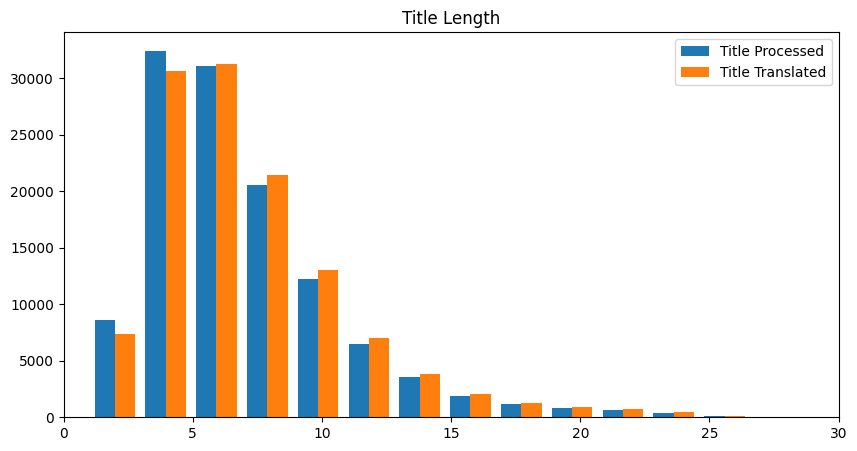

In [74]:
len_title_processed = df_translated['Title_Processed'].apply(lambda x: len(x.split()))
len_title_translated = df_translated['Title_Translated'].apply(lambda x: len(x.split()))

# plot two histograms sidd by side in one plot
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.hist([len_title_processed, len_title_translated], bins=30)
#set X-axis limit
axes.set_xlim(0, 30)
axes.set_title('Title Length')
plt.legend(['Title Processed', 'Title Translated'])
plt.show()

## Enhance Title

In [75]:
if 'df_translated' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
    df_translated = pd.read_excel(excel_file)

df_enhanced = df_translated.copy()
# Set the number of rows to process
num = df_enhanced['Title_Translated'].notnull().sum()
df_enhanced['Title_Enhanced'] = ""
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_enhanced.at[index, 'Title_Enhanced'] = enhance_title(df_enhanced.at[index, 'Title_Translated'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_enhanced.index)

# Close the progress bar
progress_bar.close()

print(df_enhanced.info())
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
display(df_enhanced.head(20))

excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_enhanced.xlsx'
df_enhanced.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m has been saved.')

Processing Rows: 100%|██████████| 120051/120051 [00:20<00:00, 5742.38 row/s]


<class 'pandas.core.frame.DataFrame'>
Index: 120051 entries, 0 to 120414
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        120051 non-null  int64 
 1   Title             120051 non-null  object
 2   Product Name      120051 non-null  object
 3   Module Name       111938 non-null  object
 4   Title_Processed   120051 non-null  object
 5   Language          120051 non-null  object
 6   Length            120051 non-null  int64 
 7   Title_Translated  120051 non-null  object
 8   Title_Enhanced    119875 non-null  object
 9   Tags              0 non-null       object
dtypes: int64(2), object(8)
memory usage: 14.1+ MB
None


,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
0,1705753,OFM Support,OFM,Base,OFM Support,en,2,OFM Support,oil field management ( OFM ),NaN
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,Rerun workflow and Create workflow option not ...,en,8,Rerun workflow and Create workflow option not ...,workflow workflow option,NaN
2,1130330,[Ext] TR- Registration Completion Notice,ECLIPSE,Eclipse 100 (Blackoil),Registration Completion Notice,en,3,Registration Completion Notice,Registration Completion Notice,NaN
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,Patch for proSource .,en,3,Patch for proSource .,Patch proSource,NaN
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,issue with ProSource services,en,4,issue with ProSource services,ProSource services,NaN
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,ProSource new License file,en,4,ProSource new License file,ProSource License file,NaN
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,License,NaN,Schlumberger Licensing Tool . not starting,en,5,Schlumberger Licensing Tool . not starting,Licensing Tool,NaN
7,1135119,Production by zone/segment,Petrel RE,Simulation,Production by zone segment,en,4,Production by zone segment,Production zone segment,NaN
8,1136751,data exchanger with client,Petrel,Geology,data exchanger with client,en,4,data exchanger with client,data exchanger client,NaN
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,"Error Unable to start external queue, but runn...",en,9,"Error Unable to start external queue, but runn...",external queue locally,NaN


../data/processed/data_enhanced.xlsx has been saved.


## Extract Tags

In [76]:
if 'df_enhanced' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_enhanced.xlsx'
    df_enhanced = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})

df_cleaned = df_enhanced.copy()
print(df_cleaned.info())
df_cleaned.head(10)

# Set the number of rows to process
num = df_cleaned['Title_Enhanced'].notnull().sum()
df_cleaned['Tags'] = ""
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_cleaned.at[index, 'Tags'] = extract_keywords(df_cleaned.at[index, 'Title_Enhanced'])
    df_cleaned.at[index, 'Length'] = count_words(df_cleaned.at[index, 'Title_Enhanced'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_cleaned.index)

# Close the progress bar
progress_bar.close()

# Remove duplicates based on 'Title' and 'ProductName' columns after translation
df_cleaned.dropna(subset=['Tags'], inplace=True)
df_cleaned.drop_duplicates(subset=['Tags', 'Product Name'], keep='first', inplace=True)
print(df_cleaned.info())

# remove the same title pointing to multiple products
n_title = df_cleaned['Tags'].value_counts()
good_title = n_title.index[n_title == 1]
print (len(good_title))

mask = df_cleaned['Tags'].isin(good_title)
df_cleaned = df_cleaned[mask]
print(df_cleaned.info())
print(df_cleaned.isnull().sum().sort_values(ascending = False))
display(df_cleaned.head(20))
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m has been saved.')

<class 'pandas.core.frame.DataFrame'>
Index: 120051 entries, 0 to 120414
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        120051 non-null  int64 
 1   Title             120051 non-null  object
 2   Product Name      120051 non-null  object
 3   Module Name       111938 non-null  object
 4   Title_Processed   120051 non-null  object
 5   Language          120051 non-null  object
 6   Length            120051 non-null  int64 
 7   Title_Translated  120051 non-null  object
 8   Title_Enhanced    119875 non-null  object
 9   Tags              0 non-null       object
dtypes: int64(2), object(8)
memory usage: 14.1+ MB
None


Processing Rows: 100%|██████████| 119875/119875 [00:18<00:00, 6547.52 row/s]


<class 'pandas.core.frame.DataFrame'>
Index: 108635 entries, 0 to 120414
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        108635 non-null  int64 
 1   Title             108635 non-null  object
 2   Product Name      108635 non-null  object
 3   Module Name       101560 non-null  object
 4   Title_Processed   108635 non-null  object
 5   Language          108635 non-null  object
 6   Length            108635 non-null  int64 
 7   Title_Translated  108635 non-null  object
 8   Title_Enhanced    108635 non-null  object
 9   Tags              108635 non-null  object
dtypes: int64(2), object(8)
memory usage: 9.1+ MB
None
102502
<class 'pandas.core.frame.DataFrame'>
Index: 102502 entries, 1 to 120414
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        102502 non-null  int64 
 1   Title           

,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,Rerun workflow and Create workflow option not ...,en,3,Rerun workflow and Create workflow option not ...,workflow workflow option,workflow option
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,Patch for proSource .,en,2,Patch for proSource .,Patch proSource,prosource patch
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,issue with ProSource services,en,2,issue with ProSource services,ProSource services,prosource service
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,ProSource new License file,en,3,ProSource new License file,ProSource License file,prosource file license
7,1135119,Production by zone/segment,Petrel RE,Simulation,Production by zone segment,en,3,Production by zone segment,Production zone segment,production segment zone
8,1136751,data exchanger with client,Petrel,Geology,data exchanger with client,en,3,data exchanger with client,data exchanger client,data exchanger client
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,"Error Unable to start external queue, but runn...",en,3,"Error Unable to start external queue, but runn...",external queue locally,locally external queue
10,1144906,unable to run simulation jobs on the cluster,Simulation Cluster Manager,Load Sharing Facility (LFS),unable to run simulation jobs on the cluster,en,3,unable to run simulation jobs on the cluster,simulation jobs cluster,job simulation cluster
11,1146411,Collocated co-kriging incertidumbre,Petrel,Geology,Collocated kriging incertidumbre,en,2,Collocated kriging incertidumbre,kriging incertidumbre,incertidumbre kriging
13,1154418,Access a new Studio 2020 Connection Issue,Studio,Studio Petrel,Access new Studio Connection Issue,en,3,Access new Studio Connection Issue,Access Studio Connection,connection studio access


../data/processed/data_cleaned.xlsx has been saved.


# Consolidate Product Categories

<class 'pandas.core.frame.DataFrame'>
Index: 102502 entries, 1 to 120414
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        102502 non-null  int64 
 1   Title             102502 non-null  object
 2   Product Name      102502 non-null  object
 3   Module Name       96122 non-null   object
 4   Title_Processed   102502 non-null  object
 5   Language          102502 non-null  object
 6   Length            102502 non-null  int64 
 7   Title_Translated  102502 non-null  object
 8   Title_Enhanced    102502 non-null  object
 9   Tags              102502 non-null  object
dtypes: int64(2), object(8)
memory usage: 8.6+ MB
None


,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,Rerun workflow and Create workflow option not ...,en,3,Rerun workflow and Create workflow option not ...,workflow workflow option,workflow option
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,Patch for proSource .,en,2,Patch for proSource .,Patch proSource,prosource patch
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,issue with ProSource services,en,2,issue with ProSource services,ProSource services,prosource service
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,ProSource new License file,en,3,ProSource new License file,ProSource License file,prosource file license
7,1135119,Production by zone/segment,Petrel RE,Simulation,Production by zone segment,en,3,Production by zone segment,Production zone segment,production segment zone
...,...,...,...,...,...,...,...,...,...,...
120396,688098,Petrel RE 分区产水设置,Petrel RE,Other,Petrel RE 分区产水设置,zh,5,PetrelRE zoned water production settings,PetrelRE zoned water production settings,zoned water setting production petrelre
120397,688296,Petrel RE 实现以POLYGON为界定义属性,Petrel RE,Other,Petrel RE 实现以 POLYGON 为界定义属性,zh,6,PetrelRE implements defining properties with P...,PetrelRE implements defining properties POLYGO...,defining property implement petrelre polygon b...
120398,688298,FM 根据条件生产井自动转注,Petrel RE,Other,FM 根据条件生产井自动转注,zh,8,FM automatically transfers injection to produc...,modeling automatically transfers injection pro...,automatically based condition transfer product...
120399,604829,Shell LNG CP - Lost alarms history.,ConnectedProduction,Core,Shell LNG CP Lost alarms history.,zh,6,Shell LNG CP Lost alarms history.,Shell LNG CP Lost alarms history,history cp lng lost alarm shell


<class 'pandas.core.frame.DataFrame'>
Index: 100219 entries, 1 to 120414
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        100219 non-null  int64 
 1   Title             100219 non-null  object
 2   Product Name      100219 non-null  object
 3   Title_Processed   100219 non-null  object
 4   Language          100219 non-null  object
 5   Length            100219 non-null  int64 
 6   Title_Translated  100219 non-null  object
 7   Title_Enhanced    100219 non-null  object
 8   Tags              100219 non-null  object
dtypes: int64(2), object(7)
memory usage: 7.6+ MB
None


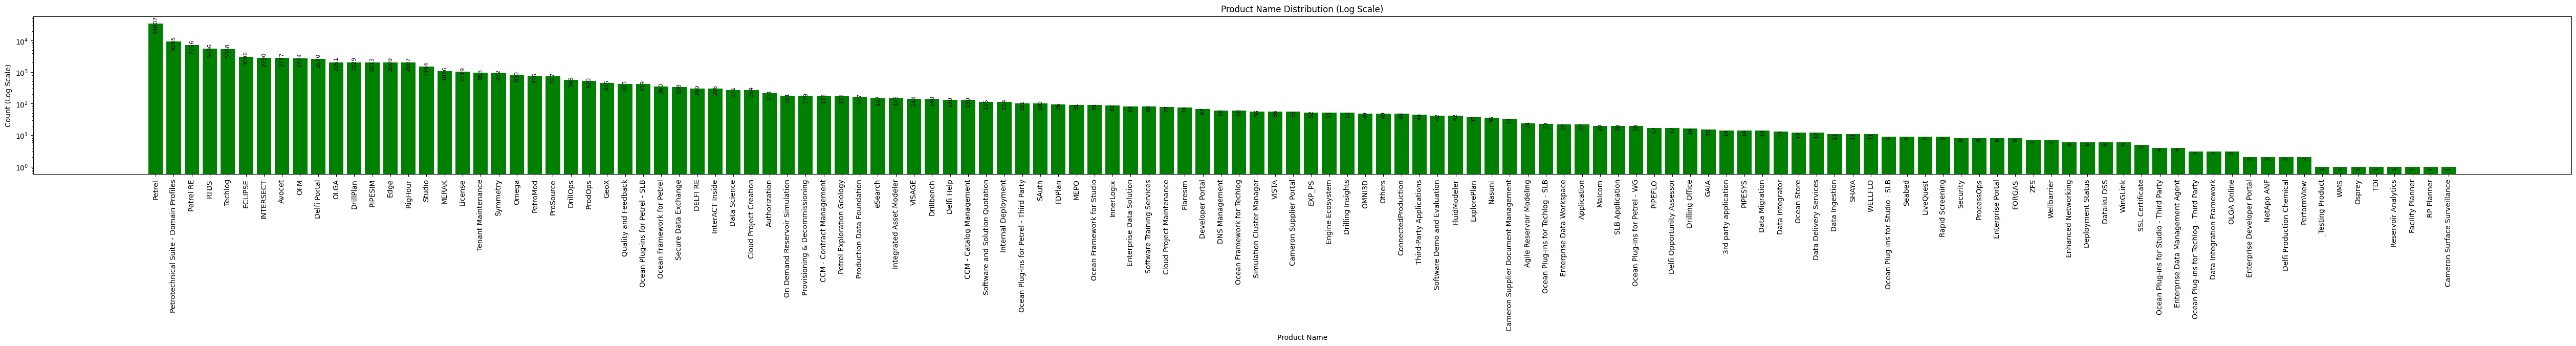

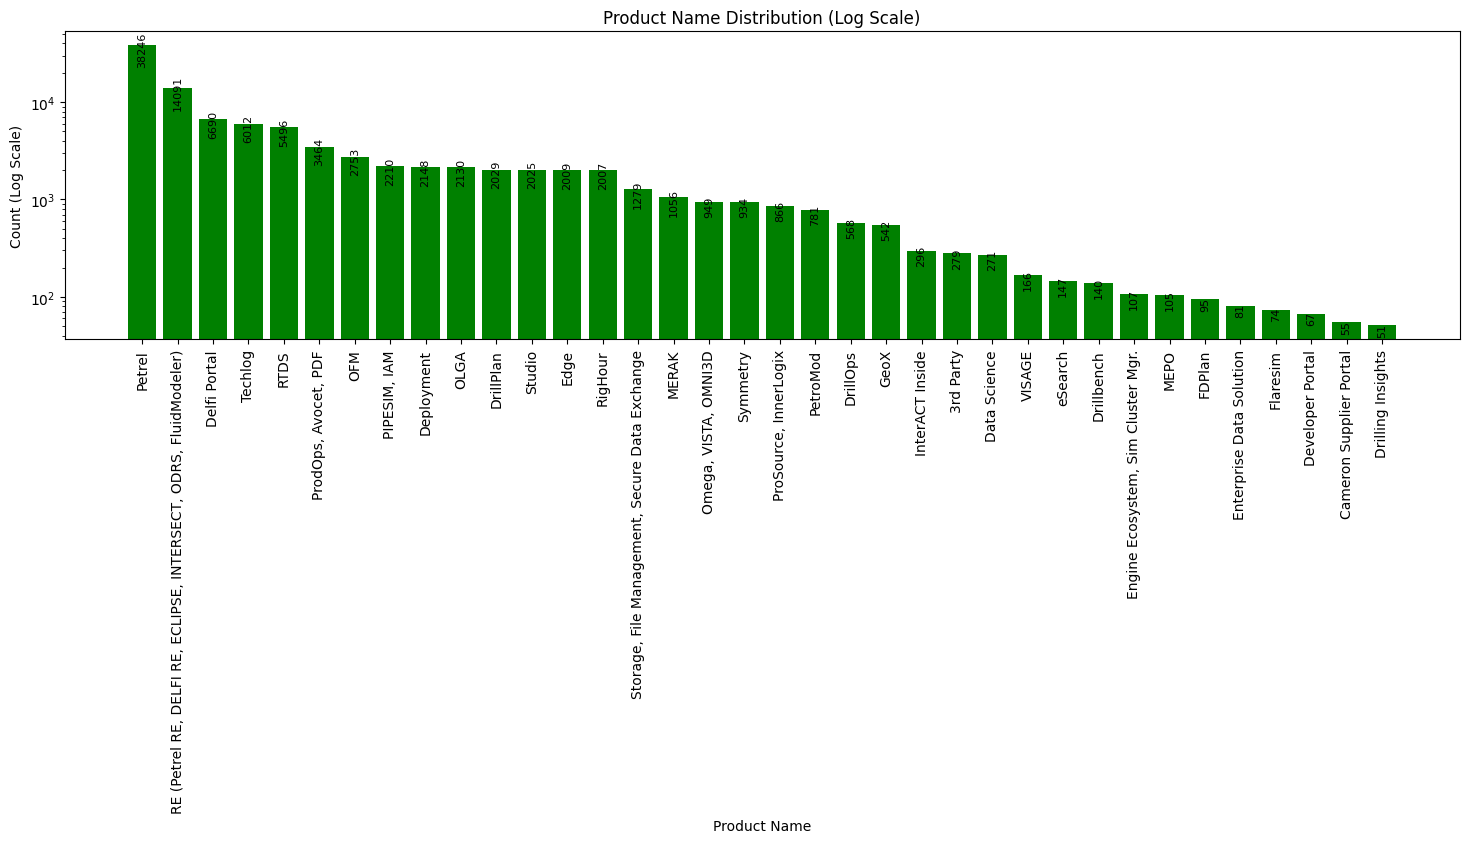

../data/processed/data_consolidated.xlsx has been saved.
../data/processed/data_train.xlsx has been saved.
../data/processed/data_test.xlsx has been saved.


In [77]:
if 'df_cleaned' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
    df_cleaned = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_cleaned.info())

df_consolidated = df_cleaned.copy()
display(df_consolidated.head(-10))

dict_category_mapping = {
    'Others': ['Other'],
    'Studio': ['Ocean Framework for Studio'],
    'Techlog': ['Ocean Framework for Techlog'],
    'PIPESIM, IAM': ['PIPESIM', 'Integrated Asset Modeler'],
    'Omega, VISTA, OMNI3D': ['Omega', 'OMEGA', 'VISTA', 'OMNI3D'],
    'ProSource, InnerLogix': ['ProSource', 'EXP_PS', 'InnerLogix'],
    'ProdOps, Avocet, PDF': ['ProdOps', 'Production Data Foundation', 'Avocet'],
    'Engine Ecosystem, Sim Cluster Mgr.': ['Engine Ecosystem', 'Simulation Cluster Manager'],
    'Petrel': ['Petrel Exploration Geology', 'Petrel Project Explorer', 'Ocean Framework for Petrel', 'Ocean Plug-ins for Petrel - SLB'],
    'Storage, File Management, Secure Data Exchange': ['Storage', 'Nasuni', 'File Management', 'Secure Data Exchange'],
    'Delfi Portal': ['Delfi Portal', 'SAuth', 'License', 'Licensing', 'Environment', 'Authorization', 'VM', 'TGX', 'Remote App'],
    'RE (Petrel RE, DELFI RE, ECLIPSE, INTERSECT, ODRS, FluidModeler)': ['Petrel RE', 'DELFI RE', 'ECLIPSE', 'INTERSECT', 'On Demand Reservoir Simulation', 'FluidModeler'],
    
    '3rd Party': ['Ocean Plug-ins for Petrel - Third party', 'Ocean Plug-ins for Petrel - Third Party',
                '3rd party application', 'Third-Party Applications', 'Ocean Plug-ins for Techlog - Third Party', 
                'App – Third Party', 'App - Third Party'],
    
    'Deployment': ['Provisioning & Decommissioning', 'Software Demo and Evaluation', 'Internal Deployment', 'Image', 
                'Deployment Status', "New PTS Deployment", 'Remove PTS Deployment', 'System Deployment', 'Deployment',
                'Cloud Project Creation', 'Cloud Project Maintenance', 'Tenant Maintenance', 'DNS Management',
                'CCM - Contract Management', 'CCM - Catalog Management', 'Software and Solution Quotation']
}
# Use Module Name to replace Product Name for all 'Petrotechnical Suite - Domain Profiles'

df_consolidated.loc[df_consolidated['Product Name'] == 'Petrotechnical Suite - Domain Profiles', 'Product Name'] = df_consolidated['Module Name']
df_consolidated.drop(columns=['Module Name'], inplace=True)
df_consolidated.dropna(subset=['Product Name'], inplace=True)

# combine the following products into corresponding categories
for category, products in dict_category_mapping.items():
    df_consolidated.loc[df_consolidated['Product Name'].isin(products), 'Product Name'] = category

#drop the rows which Product Name is 'Quality and Feedback' and 'Software Training Services'
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Others']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Delfi Help']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Quality and Feedback']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Software Training Services']

#Drop the products which have less than 50 records
df_consolidated = df_consolidated.groupby('Product Name').filter(lambda x : len(x)>50)

print(df_consolidated.info())

hist_by_labels(df_cleaned, 'Product Name', log=True, horizontal=True)
hist_by_labels(df_consolidated, 'Product Name', top=None, log=True, horizontal=True)

from sklearn.model_selection import train_test_split

# split the data into train and test sets with 90% and 10% respectively of each product
df_train, df_test = train_test_split(df_consolidated, test_size=0.1, random_state=42, stratify=df_consolidated['Product Name'])

# Export the DataFrame to Excel
excel_file_consolidated = f'{DATA_FOLDER_PATH_PROCESSED}/data_consolidated.xlsx'
df_consolidated.to_excel(excel_file_consolidated, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_consolidated}\033[0m has been saved.')

excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train.to_excel(excel_file_train, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_train}\033[0m has been saved.')

excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test.to_excel(excel_file_test, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_test}\033[0m has been saved.')

# Data Augmentation

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'

df_train = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_train.info())
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:
# function to augment a dataframe with a given product name
def augment_product_data(df, target_size=500):

    result = pd.DataFrame(columns=df.columns)
    
    df_size = len(df)
    lang_agent = ['fr', 'ja', 'ru', 'es', 'ko', 'zh', 'pt', 'ar', 'de', 'it']
    
    num_iterations = min(target_size // df_size-1, len(lang_agent))
    
    for i in range(num_iterations):
        df_temp = df.copy()
        translated_titles = df_temp["Title_Translated"].tolist()
        translated_titles = translate_array(translated_titles, src_lang='en', tar_lang=lang_agent[i],length_limit=1250)
        translated_titles = translate_array(translated_titles, src_lang=lang_agent[i], tar_lang='en',length_limit=1250)

        df_temp['Title_Translated'] = translated_titles
        result = pd.concat([result, df_temp], ignore_index=True)
    return result

TARGET_SIZE = 5000
df_augmented = pd.DataFrame(columns=df_train.columns)

# filter the products which have less than 2500 records
grouped = df_train.groupby("Product Name")
# grouped = grouped.filter(lambda x : len(x)>2500)

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Processing")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for product, group in grouped:
    if (len(group) > TARGET_SIZE//2):
        pbar.update(1)  # Update the progress bar
        continue
    pbar.set_description(f"Processing [{product}/{len(group)}]")
    df_product = augment_product_data(group, target_size=TARGET_SIZE)

    processed_groups.append(df_product)
    pbar.update(1)  # Update the progress bar
# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_additional = pd.concat(processed_groups, ignore_index=True)
df_augmented = pd.concat([df_augmented, df_additional], ignore_index=True)


In [ ]:
results = df_augmented.copy()

df_augmented = pd.concat([df_train, df_augmented], ignore_index=True)

In [ ]:
print(results.info())
df_augmented.info()

In [ ]:
df_augmented['Title_Cleaned'] = df_augmented['Title_Translated'].apply(final_clean_up)
df_augmented.dropna(subset=['Title_Cleaned'], inplace=True)
df_augmented['Length'] = df_augmented['Title_Cleaned'].apply(count_words)
df_augmented.drop_duplicates(subset=['Title_Cleaned', 'Product Name'], keep='first', inplace=True)
df_augmented.drop_duplicates(subset=['Title_Cleaned'], inplace=True)

print(df_train.info())
print(df_augmented.info())

hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_augmented, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:

# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_augmented.xlsx'

# Export the DataFrame to Excel
df_augmented.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index